## Лабораторная работа № 1
### Изучение принципов работы байесовских сетей c использованием фреймворка Pyro и библиотеки ArviZ

#### Задачи работы:
1. Познакомиться с байесовским моделированием и организацией байесовских сетей.
2. Изучить принципы создания байесовских моделей для решения стандартных задач машинного обучения.
3. Познакомиться с байесовским подходом к заполнению пропусков в данных.
4. Получить навыки создания и обучения моделей, а также получения результатов предсказания на их основе, с использованием фреймворка Pyro.
5. Получить навыки интерпретации байесовских моделей с использованием библиотеки ArviZ.

Устанавливаем фреймворк вероятностного программирования [Pyro](https://pyro.ai/):

In [ ]:
!pip install pyro-ppl

Подключаем библиотеки анализа и визуализации данных, необходимые в процессе работы.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

%matplotlib inline

d:\Рабочая папка\Sience\ML_labs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Уточняем версию фреймворка Pyro. На момент написания работы, самая свежая версия -- __1.9.1__.

In [2]:
pyro.__version__

'1.9.1'

В работе анализируется датасет [Credit Risk Dataset](https://www.kaggle.com/datasets/laotse/credit-risk-dataset), который содержит информацию о клиентах, получивших кредит.

Данный датасет был разделен на две части (train и predict), предназначенные для обучения байесовской модели и получения по ней предсказаний соответственно.

Скачиваем [тренировочный](https://drive.google.com/file/d/1HnBdQodlt3MyAd6NVw0qOKxQYVbc7X8s/view?usp=sharing) и [тестовый](https://drive.google.com/file/d/1n9XjptSj8j4BL1gFwxXBFN69MtjsSPQE/view?usp=sharing) датасеты в локальную папку.

Загрузим датасет для обучения модели и посмотрим на него.

In [ ]:
!gdown 1HnBdQodlt3MyAd6NVw0qOKxQYVbc7X8s
!gdown 1n9XjptSj8j4BL1gFwxXBFN69MtjsSPQE

In [ ]:
df_train_name = "/content/credit_risk_dataset_train.csv"
df_train = pd.read_csv(df_train_name)
df_train

In [4]:
df_train = pd.read_csv('data/Social Media Users.csv')
df_train

,Platform,Owner,Primary Usage,Country,Daily Time Spent (min),Verified Account,Date Joined
0,WhatsApp,Meta,Messaging,Switzerland,113.94,Yes,2019-03-03
1,WeChat,Tencent,Messaging and social media,Madagascar,49.63,Yes,2023-09-21
2,Snapchat,Snap Inc.,Multimedia messaging,Pitcairn Islands,29.01,Yes,2020-12-13
3,Instagram,Meta,Photo and video sharing,Timor-Leste,295.43,Yes,2019-04-21
4,Threads,Meta,Text-based social networking,Bermuda,71.78,No,2015-07-14
...,...,...,...,...,...,...,...
9995,Pinterest,Pinterest Inc.,Visual discovery and bookmarking,Morocco,249.12,No,2024-04-23
9996,Reddit,Reddit Inc.,Discussion forums and communities,Cape Verde,111.38,Yes,2017-03-06
9997,Quora,Quora Inc.,Q&A knowledge sharing,Poland,87.88,No,2018-05-17
9998,Quora,Quora Inc.,Q&A knowledge sharing,Lao People's Democratic Republic,205.69,Yes,2019-10-07


Описание столбцов датасета представлено ниже.

|         **Признак**        |                    **Значение**                   |
|:--------------------------:|:-------------------------------------------------:|
| Platform                   | Наименование платформы                            |
| Owner                      | Владелец платфрмы                                 |
| Primary Usage              | Сфера в деятельности платформы                    |
| Country                    | Регион, в котором находится ползователь           |
| Daily Time Spent (min)     | Время, проведенное пользователем в сети в минутах |
| Verified Account           | Подтвержденная уч. запись                         |
| Date Joined                | Дата регистрации пользователя                     |

В датасете наблюдаются признаки:

* **количественные**: Daily Time Spent
* **категориальные**: Platform, Owner, Primary Usage, Country, Verified Account.
* **дата**: Date Joined
Взглянем на формат столбцов датасета.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Platform                10000 non-null  object 
 1   Owner                   10000 non-null  object 
 2   Primary Usage           10000 non-null  object 
 3   Country                 10000 non-null  object 
 4   Daily Time Spent (min)  10000 non-null  float64
 5   Verified Account        10000 non-null  object 
 6   Date Joined             10000 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.0+ KB


С целью упрощения анализа, оставим в датасете только некоторые столбцы.

In [ ]:
df_train = df_train[
    ["person_age", "person_income", "person_home_ownership", "loan_intent",
     "loan_amnt", "loan_int_rate", "cb_person_default_on_file",
     "loan_status"]
]

Посмотрим, содержат ли столбцы пропущенные значения.

In [6]:
df_train.isnull().sum()

Platform                  0
Owner                     0
Primary Usage             0
Country                   0
Daily Time Spent (min)    0
Verified Account          0
Date Joined               0
dtype: int64

Видно, процентная ставка указана не для всех клиентов. Пропущенные значения будем заполнять в дальнейшем __с применением байесовской модели__.

Посмотрим на статистику данных.

In [7]:
df_train.describe()

,Daily Time Spent (min)
count,10000.000000
mean,152.211145
std,85.142750
min,5.020000
25%,78.920000
50%,152.735000
75%,225.642500
max,300.000000


In [ ]:
df_train.sort_values(by="person_age", ascending=False).head(10)

Посмотрим на количество значений категориальных признаков.

In [9]:
for col in ["Verified Account",
            "Country",
            "Primary Usage"]:
    print(df_train[col].value_counts(), end="\n\n")

Verified Account
No     5006
Yes    4994
Name: count, dtype: int64

Country
Congo                               82
Korea                               78
Botswana                            56
Suriname                            55
Armenia                             54
                                    ..
Russian Federation                  28
Liechtenstein                       28
Montenegro                          27
Saint Kitts and Nevis               26
Lao People's Democratic Republic    26
Name: count, Length: 243, dtype: int64

Primary Usage
Messaging                            1375
Discussion forums and communities     764
Photo and video sharing               745
Messaging and social media            742
Text-based social networking          724
Short-form videos                     716
Professional networking               710
Social networking                     709
Video sharing                         709
Microblogging                         706
Visual discovery and 

Количество различных значений категориальных столбцов невелико, специальным образом обрабатывать их не нужно.

Построим гистограммы количественных признаков.

In [19]:
Verified_Account = df_train["Verified Account"].nunique()
Country = df_train["Country"].nunique()
Primary_Usage = df_train["Primary Usage"].nunique()

print(f'{Verified_Account}\n{Country}\n{Primary_Usage}')

2
243
13


<Axes: >

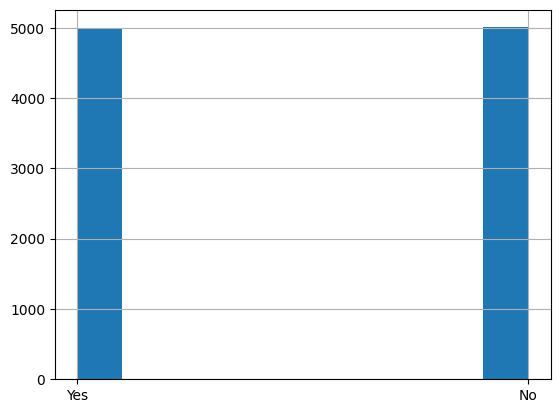

In [12]:
df_train["Verified Account"].hist()

<Axes: >

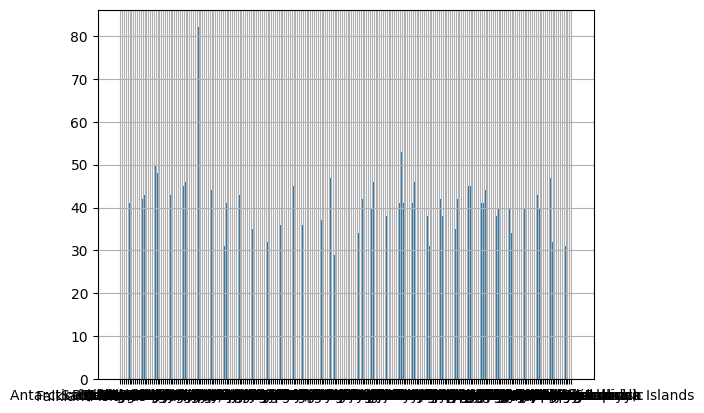

In [15]:
df_train["Country"].hist(bins=1000)

<Axes: >

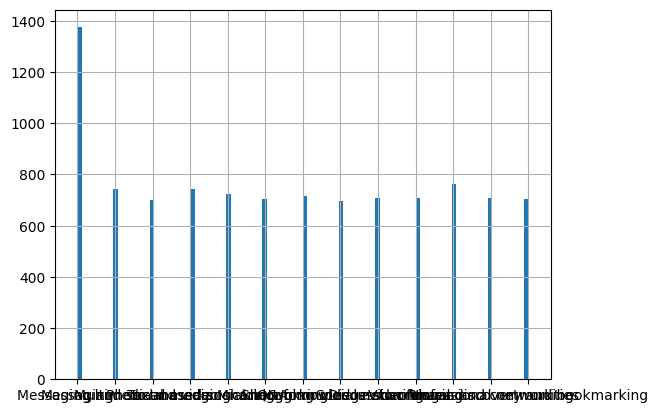

In [14]:
df_train["Primary Usage"].hist(bins=100)

In [ ]:
df_train[df_train["person_income"] < 500000]["person_income"].hist(bins=100)

Приведем типы столбцов датасета к корректным.

In [ ]:
person_home_ownership_cat = pd.CategoricalDtype(
    categories=["RENT", "MORTGAGE", "OWN", "OTHER"],
    ordered=False
)

loan_intent_cat = pd.CategoricalDtype(
    categories=["EDUCATION", "MEDICAL", "VENTURE", "PERSONAL",
                "DEBTCONSOLIDATION", "HOMEIMPROVEMENT"],
    ordered=False
)

cb_person_default_on_file_cat = pd.CategoricalDtype(
    categories=["N", "Y"],
    ordered=False
)

In [ ]:
df_train = df_train.astype(
    {
        "person_age": np.float64,
        "person_income": np.float64,
        "person_home_ownership": person_home_ownership_cat,
        "loan_intent": loan_intent_cat,
        "loan_amnt": np.float64,
        "loan_int_rate": np.float64,
        "cb_person_default_on_file": cb_person_default_on_file_cat,
        "loan_status": np.int64
    }
)

df_train.info()

Выполним кодирование категориальных признаков и стандартизацию количественных.

Признак с процентной ставкой, пустые значения в котором будем заполнять с помощью байесовской модели, оставим без изменений.

In [ ]:
num_features = ["person_age", "person_income", "loan_amnt"]
cat_features = ["person_home_ownership", "loan_intent",
                "cb_person_default_on_file"]

column_transformer = ColumnTransformer([
    ("cat_transformer", OrdinalEncoder(dtype='int'), cat_features),
    ("num_transformer", StandardScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

In [ ]:
column_transformer.set_output(transform="pandas")
df_train = column_transformer.fit_transform(df_train)
df_train

Создадим функцию, преобразующую данные в датафрейме в тензоры PyTorch.

In [ ]:
def convert_df_to_tensors(data: pd.DataFrame) -> dict[str, torch.Tensor]:
    tensors: dict[str, torch.Tensor] = {}
    for column in data.columns:
        tensors[column] = torch.tensor(data[column].values)
    return tensors

Поставим __задачу классификации__ следующим образом: предсказать вероятность возврата кредита клиентом по его характеристикам, представленным в датасете. Одновременно с решением задачи классификации следует заполнить пропуски в столбце "Процентная ставка". Требуется визуализовать априорные и апостериорные распределения коэффициентов байесовской модели, а также распределение целевой переменной для произвольного объекта тестового датасета.

Байесовскую модель зададим следующим образом. Курсивом обозначены случайные переменные, прямым шрифтом -- признаки из датасета.

$p(loan\_status, loan\_int\_rate, b\_person\_age, b\_person\_income, b\_loan\_amnt, b\_loan\_int\_rate, b\_person\_home\_ownership, b\_loan\_intent, b\_cb\_person\_default\_on\_file, mu\_loan\_int\_rate, std\_loan\_int\_rate) = p(loan\_status, loan\_int\_rate \; | \; b\_person\_age, b\_person\_income, b\_loan\_amnt, b\_loan\_int\_rate, b\_person\_home\_ownership, b\_loan\_intent, b\_cb\_person\_default\_on\_file, mu\_loan\_int\_rate, std\_loan\_int\_rate) \cdot p(mu\_loan\_int\_rate) \cdot p(std\_loan\_int\_rate) \cdot p(b\_person\_age) \cdot p(b\_person\_income) \cdot p(b\_loan\_amnt) \cdot p(b\_loan\_int\_rate) \cdot p(b\_person\_home\_ownership) \cdot p(b\_loan\_intent) \cdot p(b\_cb\_person\_default\_on\_file)$

<p>&nbsp;</p>

$p(loan\_status, loan\_int\_rate \; | \; loan\_int\_rate, b\_person\_age, b\_person\_income, b\_loan\_amnt, b\_loan\_int\_rate, b\_person\_home\_ownership, b\_loan\_intent, b\_cb\_person\_default\_on\_file, mu\_loan\_int\_rate, std\_loan\_int\_rate) = \prod_{i=1}^{N} p(loan\_status_i \; | \; loan\_int\_rate, b\_person\_age, b\_person\_income, b\_loan\_amnt, b\_loan\_int\_rate, b\_person\_home\_ownership, b\_loan\_intent, b\_cb\_person\_default\_on\_file) \cdot p(loan\_int\_rate_i \; | \; mu\_loan\_int\_rate, std\_loan\_int\_rate)$

<p>&nbsp;</p>

$p(loan\_status_i \; | \; loan\_int\_rate, b\_person\_age, b\_person\_income, b\_loan\_amnt, b\_loan\_int\_rate, b\_person\_home\_ownership, b\_loan\_intent, b\_cb\_person\_default\_on\_file) = \mathcal B \left[ {\sigma(logits_i)} \right]$

<p>&nbsp;</p>

$logits_i = b\_person\_age \cdot \text{person_age}_i + b\_person\_income \cdot \text{person_income}_i + b\_loan\_amnt \cdot \text{loan_amnt}_i + b\_person\_home\_ownership_{\text{person_home_ownership}_i} + b\_loan\_intent_{\text{loan_intent}_i} + b\_cb\_person\_default\_on\_file_{\text{b_cb_person_default_on_file}_i} + b\_loan\_int\_rate \cdot loan\_int\_rate_i$

<p>&nbsp;</p>

$p(loan\_int\_rate_i \; | \; mu\_loan\_int\_rate, std\_loan\_int\_rate) = \mathcal{N}(mu\_loan\_int\_rate, \, std\_loan\_int\_rate)$

<p>&nbsp;</p>

$b\_person\_age \sim \mathcal{N}(0,\,1)$

$b\_person\_income \sim \mathcal{N}(0,\,1)$

$b\_loan\_amnt \sim \mathcal{N}(0,\,1)$

$b\_loan\_int\_rate \sim \mathcal{N}(0,\,1)$

$b\_person\_home\_ownership_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,3]$

$b\_loan\_intent_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,5]$

$b\_cb\_person\_default\_on\_file_i \sim \mathcal{N}(0,\,1), \: i \in [0,\,1]$

$mu\_loan\_int\_rate \sim \mathcal{N}(0,\,1)$

$std\_loan\_int\_rate \sim |\mathcal{N}(0,\,1)|$

<p>&nbsp;</p>

Переменная $loan\_int\_rate$ считается __наблюдаемой__ со значениями:

$loan\_int\_rate_i \sim \begin{cases}
    \delta(\text{loan_int_rate}_i) & \text{if loan_int_rate$_i$ is not None}, \\
    impute\_loan\_int\_rate(mu\_loan\_int\_rate,\,std\_loan\_int\_rate) & \text{otherwise}.
\end{cases}
$

Здесь $impute\_loan\_int\_rate = \mathcal{N}(mu\_loan\_int\_rate,\,std\_loan\_int\_rate)$ -- вспомогательная случайная переменная, предназначенная для "замены" отсутствующего значения loan_int_rate.


Определим __модель__ в виде следующей функции.

In [ ]:
def model(data: dict[str, torch.Tensor], is_training: bool = False) -> None:
    b_person_age = pyro.sample("b_person_age", dist.Normal(0, 1))
    b_person_income = pyro.sample("b_person_income", dist.Normal(0, 1))
    b_loan_amnt = pyro.sample("b_loan_amnt", dist.Normal(0, 1))
    b_loan_int_rate = pyro.sample("b_loan_int_rate", dist.Normal(0, 1))

    logits = b_person_age * data["person_age"]
    logits += b_person_income * data["person_income"]
    logits += b_loan_amnt * data["loan_amnt"]

    mu_loan_int_rate = pyro.sample("mu_loan_int_rate", dist.Normal(0, 1))
    std_loan_int_rate = pyro.sample("std_loan_int_rate", dist.HalfNormal(1))

    impute_loan_int_rate = pyro.sample(
        "impute_loan_int_rate", dist.Normal(
            mu_loan_int_rate,
            std_loan_int_rate
        ).mask(False)
    )

    loan_int_rate = data["loan_int_rate"]
    loan_int_rate = torch.where(torch.isnan(loan_int_rate),
                                impute_loan_int_rate,
                                loan_int_rate)


    logits += b_loan_int_rate * loan_int_rate

    b_person_home_ownership = pyro.sample("b_person_home_ownership",
                                          dist.Normal(0, 1).expand([4]))
    b_loan_intent = pyro.sample("b_loan_intent", dist.Normal(0, 1).expand([6]))
    b_cb_person_default_on_file = pyro.sample("b_cb_person_default_on_file",
                                              dist.Normal(0, 1).expand([2]))

    logits += b_person_home_ownership[data["person_home_ownership"]]
    logits += b_loan_intent[data["loan_intent"]]
    logits += b_cb_person_default_on_file[
        data["cb_person_default_on_file"]]

    obs = None if not is_training else data["loan_status"].float()

    with pyro.plate("N", data["loan_status"].shape[0]):
        pyro.sample("loan_int_rate",
                    dist.Normal(mu_loan_int_rate, std_loan_int_rate),
                    obs=loan_int_rate)
        pyro.sample("loan_status",
                    dist.Bernoulli(logits=logits),
                    obs=obs)

Визуализируем графическую вероятностную модель, соответствующую совместному распределению данных и весов.

In [ ]:
pyro.render_model(model,
                  model_args=(convert_df_to_tensors(df_train), True),
                  render_distributions=True,
                  render_params=True)

Посмотрим на форму всех переменных в модели.

In [ ]:
trace = pyro.poutine.trace(model).get_trace(
    convert_df_to_tensors(df_train), True)
print(trace.format_shapes())

Выполним **инференс модели** с использованием марковских последовательностей Монте-Карло (MCMC).

Данная процедура выполняет нахождение апостериорного распределения весов модели, многократно сэмплируя из совместного распределения и приводя распределение сэмплов к апостериорному распределению весов.

Процедура сэмплирования может быть __достаточно длительной__.

In [ ]:
num_of_samples = 400
burn_in_samples = 100

mcmc = MCMC(NUTS(model, jit_compile=True),
            num_samples=num_of_samples, warmup_steps=burn_in_samples)
mcmc.run(convert_df_to_tensors(df_train), True)
mcmc.summary()

После выполнения процедуры сэмплирования проверьте значения в сводке параметров:
* n_eff: должен быть близок к количеству семплов, определяет степень скоррелированности полученных семплов;
* r_hat: должен быть близким к единице, что указывает на сходимость метода.

Получить сэмплы из апостериорного распределения весов можно следующим образом:

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_samples

После выполнения инференса займёмся процедурой __предсказания__ с использованием обученной модели.

Загрузим датасет с тестовыми данными и посмотрим на него.

In [ ]:
df_predict_name = "/content/credit_risk_dataset_predict.csv"
df_predict = pd.read_csv(df_predict_name)
df_predict

Выполним над тестовым датасетом те же преобразования признаков, что и над тренировочным:

In [ ]:
df_predict = column_transformer.transform(df_predict)
df_predict

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием апостериорных распределений весов (полученных после обучения модели).

In [ ]:
posterior_predictive = Predictive(model, posterior_samples)(
    convert_df_to_tensors(df_predict))
posterior_predictive

Получим распределение наблюдаемых переменных для каждого объекта из тестовой выборки с использованием априорных распределений весов (полученных до обучения модели).

In [ ]:
prior = Predictive(model, num_samples=num_of_samples)(
    convert_df_to_tensors(df_predict))
prior

Сформируем данные для визуализации с помощью библиотеки [ArViZ](https://python.arviz.org/en/stable/).

In [ ]:
pyro_data = az.from_pyro(
    mcmc, prior=prior, posterior_predictive=posterior_predictive
)
pyro_data

Визуализируем апостериорные распределения всех латентных переменных. "Качество" формы графиков зависит, в том числе, от числа семплов. Увеличение количества семплов приводит к формированию более точных распределений, но и увеличивает расчётное время.

In [ ]:
az.plot_posterior(pyro_data);

Визуализируем априорные и апостериорные распределения для каждой латентной переменной и сравним их.

In [ ]:
axes = az.plot_density(
    [pyro_data.posterior, pyro_data.prior],
    data_labels=["Posterior", "Prior"],
    shade=0.2
)

Визуализируем семейство распределений латентных переменных, полученных моделью, и сравним их с эмпирическим распределением, сформированным из тестового датасета.

In [ ]:
az.plot_ppc(pyro_data);

Посмотрим на апостериорные распределения латентных переменных (весов модели) всесте с "трассой" -- набором сэмплов, полученных в процессе выполнения инференса методом MCMC.

In [ ]:
az.plot_trace(pyro_data)
plt.gcf().tight_layout()

Визуализируем распределение переменной статуса кредита (целевая бинарная переменная, показывающая, возвращен ли клиентом кредит) для одного случайного клиента. Красной пунктирной линией показано истинное значение целевой переменной у данного объекта.

In [ ]:
df_predict_one = df_predict.sample(n=1)

posterior_predictive_one = Predictive(model, posterior_samples)(
    convert_df_to_tensors(df_predict_one))
ser = pd.Series(
    posterior_predictive_one["loan_status"].detach().numpy().squeeze()
)
print("Ground True value: ", df_predict_one["loan_status"].values.squeeze())
print("Probability of label to be one: ", ser.mean())
print("Distribution:")
result = plt.hist(ser, color='c', edgecolor='k', alpha=0.65)
plt.axvline(ser.mean(), color='r', linestyle='dashed', linewidth=1)

Сформируем фрагмент датафрейма с результатами предсказаний.

In [ ]:
df_result = df_predict.copy()

In [ ]:
pred_mean = posterior_predictive['loan_status'].numpy().mean(axis=0)
pred_std  = posterior_predictive['loan_status'].numpy().std(axis=0)

df_result["loan_status_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(pred_mean, pred_std)
]

loan_mean = posterior_predictive['loan_int_rate'].numpy().mean(axis=0)
loan_std  = posterior_predictive['loan_int_rate'].numpy().std(axis=0)

df_result["loan_int_rate_pred"] = [
    f"{mean:.2f} ± {std:.2f}" for mean, std in zip(loan_mean, loan_std)
]

df_result[["loan_int_rate",
           "loan_int_rate_pred",
           "loan_status",
           "loan_status_pred"]]

Данные результаты позволяют получить представление о качестве работы модели.

### Индивидуальное задание

Опираясь на представленное исследование и используя его в качестве образца, **выполните аналогичные действия с выбранным Вами датасетом**.

В процессе работы:

1. Выберите датасет, содержащий табличные данные. Датасеты можно найти, например, на [Kaggle](https://www.kaggle.com/datasets) и [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). __Хотя бы один столбец__ датасета (*количественный!*) должен содержать пропуски.
2. Выполните __разведочный анализ__ датасета, выполните требуемые __преобразования признаков__.
3. Разделите датасет на __обучающую__ и __тестовую__ части.
4. Поставьте задачу __классификации__ или __регрессии__ для данных из датасета.
5. Составьте __байесовскую модель__ для решения поставленной задачи и определения пропущенных данных. Запишите совместное распределение наблюдаемых и латентных переменных (данных и весов соответственно), выражения правдоподобия и априорных распределений.
6. __Запрограммируйте__ модель с использованием библиотеки Pyro. Получите изображение __графической вероятностной модели__, сформированной Pyro.
7. __Обучите__ вероятностную модель с использованием MCMC.
8. __Визуализируйте__ априорные и апостериорные распределения весов модели, а также "трассы", полученные в процессе сэмплирования. Критически оцените полученный результат.
9. __Визуализируйте__ эмпирические распределения наблюдаемых переменных из тестовой части датасета и сравните их с семейством предиктивных распределений, полученных моделью. Критически оцените полученный результат.
10. Для произвольного объекта из тестовой части датасета получите __предиктивное распределение__ наблюдаемых переменных и соотнесите его с точным значением соответствующих параметров рассматриваемого объекта.
11. Выведите фрагмент тестовой части датасета с добавленными столбцами, содержащими __результаты предсказания__. Критически оцените полученные результаты.
12. Сделайте __выводы__ по работе.

### Список вопросов для подготовки к отчету

1. Основные понятия теории вероятностей: плотность распределения, правило нормировки, совместная плотность вероятности, математическое ожидание, дисперсия, условная плотность вероятности. Условная независимость.

* **Правило нормировки**  — это условие, требующее, чтобы сумма (или интеграл) функции вероятности или плотности вероятности по всем возможным значениям случайной величины был равен единице.
* **Плотность распределения** (плотность вероятности) — это функция f(x), характеризующая распределение непрерывной случайной величины 
X и удовлетворяющая следующим условиям:
* * Неотрицательность
* * Условие нормировки
* * Вероятность попадания в интервал

    Плотность распределения является производной функцией распределения

**Совместная плотность вероятности** — это функция f(x,y), описывающая распределение пары (или большего набора) непрерывных случайных величин (X,Y) и удовлетворяющая следующим условиям:
* * Неотрицательность
* * Условие нормировки
* * Вероятность попадания в область
    
    Все аналогично плотности распределения, с учетом кол-ва интегралов, соответствующего кол-ву переменных.

**Условная независимость** — это свойство, означающее, что две случайные величины X и Y становятся независимыми при фиксированном значении третьей случайной величины Z.

---
2. Правило произведения для плотности совместного распределения.


---
3. Правило суммирования. Маргинализация случайных величин.
4. Обращение условного распределения. Теорема Байеса.
5. Сущность байесовского распределения. Примеры.
6. Понятие графических вероятностных моделей. Представление вероятностных отношений в виде графа. Байесовская сеть.
7. Наблюдаемые и латентные величины, их обозначения в графических моделях.
8. Понятие d-разделимости. Последовательная, расходящаяся и сходящаяся связи. Explaining away.
9. Нотация "планок" в графических моделях. Примеры.
10. Основные понятия классического машинного обучения: объекты, признаки, метки, целевая переменная, модель, функции ошибки, эмпирический риск. Принцип минимума эмпирического риска.
11. Классический и байесовский подходы к машинному обучению, их сравнительный анализ. Пример линейной регрессии с точки зрения обоих подходов.
12. Минимизация эмпирического риска как максимизация правдоподобия. Принципы максимальных правдоподобия и апостериорной вероятности.
13. Частотный и байесовский подходы к описанию событий в ML.
14. Постановка задачи и основная проблема байесовского инференса, способы её решения. Сопряженные распределения.
15. Методы Монте-Карло, их эффективность при решении интегралов. Сравнение с аналитическим и численным решениями. Базовый эстиматор Монте-Карло.
16. Понятие семплирования случайной величины. Способы семплирования. Теорема об обратной функции распределения и её применение для семплирования.
17. Семплирование с отклонением (Rejection sampling): алгоритм, его корректность и применимость. Свойства семплирования с отклонением.
18. Семплирование по важности (Importance sampling): алгоритм, его корректность и применимость. Forward sampling.
19. Фреймворк для вероятностного программирования Pyro. Краткая характеристика, построение вероятностных моделей с его помощью.
20. Сущность и реализация сторонних эффектов функций в Pyro. Понятие "трасс". Библиотека Poutine. Обработчики сторонных эффектов (handlers). Примеры.
21. Сущность и пробема байесовского вывода и способы её решения.
22. Марковские цепи Монте-карло. Свойство Маркова. Представление марковской цепи в виде графа. Вероятности переходов.
23. Предельное распределение марковской цепи.
24. Свойства несводимости (irreducibility) и периодичности (periodicity). Свойство стационарности. Состояние равновесия.
25. Фундаментальная теорема марковских цепей и её применение.
26. Обратимость марковской цепи. Условия детального баланса.
27. Алгоритм Метрополиса-Гастингса: сущность и принцип работы. Сравнение с семплированием с отклонением (rejection sampling).
28. Алгоритм Метрополиса-Гастингса как марковская цепь. Доказательство сходимости цепи к целевому распределению.
29. Обработка нормирующей константы в алгоритме Метрополиса-Гастингса. Этап «розжига» алгоритма.
30. Корреляция семплов в алгоритме Метрополиса-Гастингса. Понятие лага (lag). Ограничения алгоритма Метрополиса-Гастингса.
31. Подход статистической физики к задаче семплирования. Термодинамическая система. Микросостояние. Канонический ансамбль.
32. Каноническое распределение Гиббса. Функция Гамильтона. Подход к семплированию из целевого распределения.
33. Подходы к описанию динамики термодинамической системы. Уравнения Гамильтона.
34. Соответствие подходов Ньютона и Гамильтона к описанию динамики системы на примере.
35. Свойства механики Гамильтона. Обратимость, сохранение гамильтониана, сохранение фазового объёма. Теорема Лиувилля.
36. Микроканоническое распределение.
37. Численное решение уравнений Гамильтона. Методы Эйлера и Leapfrog.
38. Организация семплирования из целевого распределения, формирование канонического ансамбля для решения этой задачи. Вид канонического распределения.
39. Алгоритм HMC, основные шаги. Сравнение с алгоритмом Метрополиса-Гастингса. Недостатки алгоритма.
40. Динамические алгоритмы HMC: No-U-Turn Sampler. Основные идеи.

### Список литературы для подготовки к отчету

1. Дауни, А. Б. Байесовские модели / А. Б. Дауни ; перевод с английского В. А. Яроцкого. — Москва : ДМК Пресс, 2018. — 182 с. URL: https://e.lanbook.com/book/131695 (дата обращения: 13.02.2024). — Режим доступа: для авториз. пользователей.

2. Barber, D. Bayesian Reasoning and Machine Learning / D. Barber // Cambridge University Press, 2012. URL: [http://www0.cs.ucl.ac.uk/staff/d.barber/brml/](http://www0.cs.ucl.ac.uk/staff/d.barber/brml/) (дата обращения: 13.02.2024).

3. Bishop, M.C. Pattern Recognition and Machine Learning / M.C. Bishop // Springer, 2006. — 738 с. URL: [https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (дата обращения: 13.02.2024).

4. Pyro: официальная документация. 2024. URL: [https://pyro4ci.readthedocs.io/en/latest/](https://pyro4ci.readthedocs.io/en/latest/) (дата обращения: 13.02.2024).

5. Guilhoto, L. F. Applying Markov Chains to Monte Carlo Integration / Guilhoto, L. F. -- 2017. -- 16 с. URL: [http://math.uchicago.edu/~may/REU2017/REUPapers/Guilhoto.pdf](http://math.uchicago.edu/~may/REU2017/REUPapers/Guilhoto.pdf) (дата обращения: 05.03.2024).

6. Betancourt, M. A Conceptual Introduction to Hamiltonian Monte Carlo / M. Betancourt // arXiv.org, 2018. URL: [https://arxiv.org/pdf/1701.02434.pdf](https://arxiv.org/pdf/1701.02434.pdf) (дата обращения: 05.03.2024).

7. Hoffman, M.D. The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo / M.D. Hoffman, A. Gelman // arXiv.org, 2011. URL: [https://arxiv.org/pdf/1111.4246.pdf](https://arxiv.org/pdf/1111.4246.pdf) (дата обращения: 05.03.2024).